In [ ]:
# Authors: Chris Holdgraf <choldgraf@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from sklearn.preprocessing import scale

import mne
from mne.decoding import ReceptiveField, TimeDelayingRidge

rng = np.random.RandomState(1337)  # To make this example reproducible

In [3]:
# Read in audio that's been recorded in epochs.
path_audio = mne.datasets.mtrf.data_path()
data = loadmat(str(path_audio / "speech_data.mat"))
audio = data["spectrogram"].T
sfreq = float(data["Fs"][0, 0])
n_decim = 2
audio = mne.filter.resample(audio, down=n_decim, npad="auto")
sfreq /= n_decim

Using default location ~/mne_data for mtrf...


100%|█████████████████████████████████████| 58.1M/58.1M [00:00<00:00, 40.7GB/s]
Unzipping contents of '/Users/ilyamikheev/mne_data/mTRF_1.5.zip' to '/Users/ilyamikheev/mne_data'


Download complete in 43s (55.4 MB)


[None, None, None, None, None, None, None]

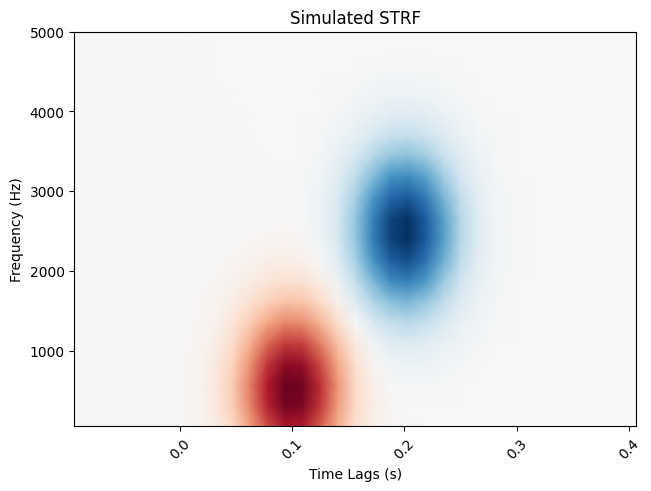

In [5]:
n_freqs = 20
tmin, tmax = -0.1, 0.4

# To simulate the data we'll create explicit delays here
delays_samp = np.arange(np.round(tmin * sfreq), np.round(tmax * sfreq) + 1).astype(int)
delays_sec = delays_samp / sfreq
freqs = np.linspace(50, 5000, n_freqs)
grid = np.array(np.meshgrid(delays_sec, freqs))

# We need data to be shaped as n_epochs, n_features, n_times, so swap axes here
grid = grid.swapaxes(0, -1).swapaxes(0, 1)

# Simulate a temporal receptive field with a Gabor filter
means_high = [0.1, 500]
means_low = [0.2, 2500]
cov = [[0.001, 0], [0, 500000]]
gauss_high = multivariate_normal.pdf(grid, means_high, cov)
gauss_low = -1 * multivariate_normal.pdf(grid, means_low, cov)
weights = gauss_high + gauss_low  # Combine to create the "true" STRF
kwargs = dict(
    vmax=np.abs(weights).max(),
    vmin=-np.abs(weights).max(),
    cmap="RdBu_r",
    shading="gouraud",
)

fig, ax = plt.subplots(layout="constrained")
ax.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax.set(title="Simulated STRF", xlabel="Time Lags (s)", ylabel="Frequency (Hz)")
plt.setp(ax.get_xticklabels(), rotation=45)

[(0.0, 7.984375),
 Text(0.5, 1.0, 'Simulated response'),
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Activity (a.u.)')]

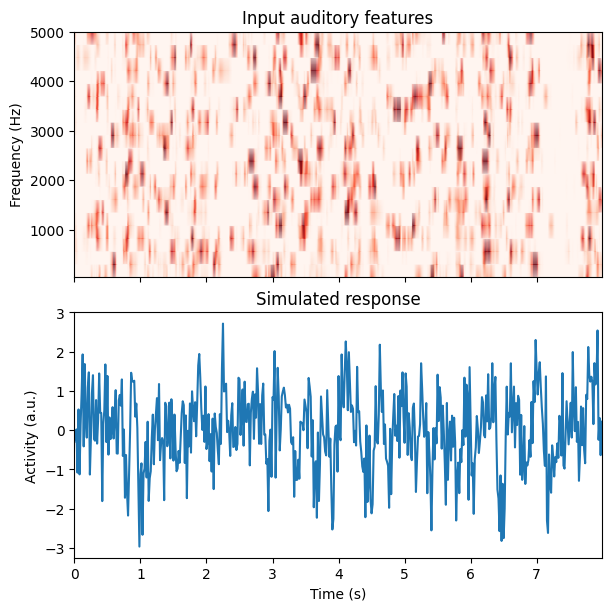

In [6]:
# Reshape audio to split into epochs, then make epochs the first dimension.
n_epochs, n_seconds = 16, 5
audio = audio[:, : int(n_seconds * sfreq * n_epochs)]
X = audio.reshape([n_freqs, n_epochs, -1]).swapaxes(0, 1)
n_times = X.shape[-1]

# Delay the spectrogram according to delays so it can be combined w/ the STRF
# Lags will now be in axis 1, then we reshape to vectorize
delays = np.arange(np.round(tmin * sfreq), np.round(tmax * sfreq) + 1).astype(int)

# Iterate through indices and append
X_del = np.zeros((len(delays),) + X.shape)
for ii, ix_delay in enumerate(delays):
    # These arrays will take/put particular indices in the data
    take = [slice(None)] * X.ndim
    put = [slice(None)] * X.ndim
    if ix_delay > 0:
        take[-1] = slice(None, -ix_delay)
        put[-1] = slice(ix_delay, None)
    elif ix_delay < 0:
        take[-1] = slice(-ix_delay, None)
        put[-1] = slice(None, ix_delay)
    X_del[ii][tuple(put)] = X[tuple(take)]

# Now set the delayed axis to the 2nd dimension
X_del = np.rollaxis(X_del, 0, 3)
X_del = X_del.reshape([n_epochs, -1, n_times])
n_features = X_del.shape[1]
weights_sim = weights.ravel()

# Simulate a neural response to the sound, given this STRF
y = np.zeros((n_epochs, n_times))
for ii, iep in enumerate(X_del):
    # Simulate this epoch and add random noise
    noise_amp = 0.002
    y[ii] = np.dot(weights_sim, iep) + noise_amp * rng.randn(n_times)

# Plot the first 2 trials of audio and the simulated electrode activity
X_plt = scale(np.hstack(X[:2]).T).T
y_plt = scale(np.hstack(y[:2]))
time = np.arange(X_plt.shape[-1]) / sfreq
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, layout="constrained")
ax1.pcolormesh(time, freqs, X_plt, vmin=0, vmax=4, cmap="Reds", shading="gouraud")
ax1.set_title("Input auditory features")
ax1.set(ylim=[freqs.min(), freqs.max()], ylabel="Frequency (Hz)")
ax2.plot(time, y_plt)
ax2.set(
    xlim=[time.min(), time.max()],
    title="Simulated response",
    xlabel="Time (s)",
    ylabel="Activity (a.u.)",
)

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

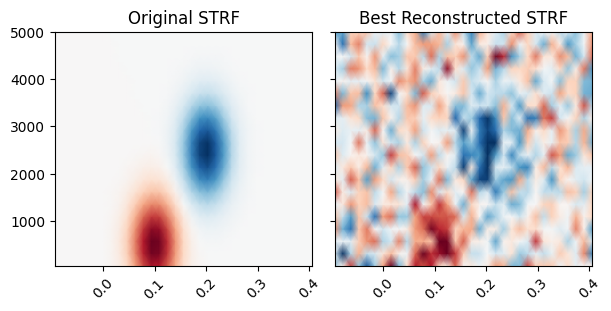

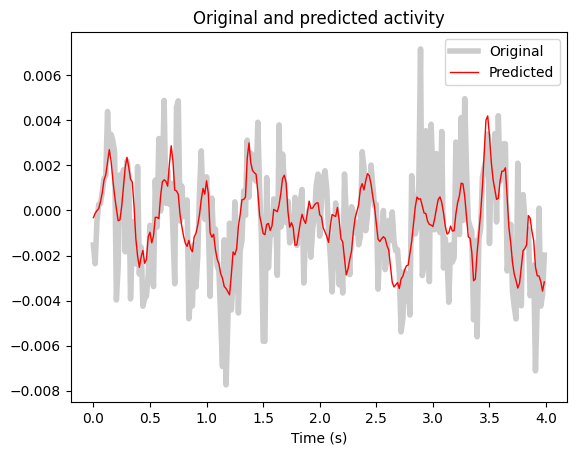

In [7]:
# Create training and testing data
train, test = np.arange(n_epochs - 1), n_epochs - 1
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
X_train, X_test, y_train, y_test = (
    np.rollaxis(ii, -1, 0) for ii in (X_train, X_test, y_train, y_test)
)
# Model the simulated data as a function of the spectrogram input
alphas = np.logspace(-3, 3, 7)
scores = np.zeros_like(alphas)
models = []
for ii, alpha in enumerate(alphas):
    rf = ReceptiveField(tmin, tmax, sfreq, freqs, estimator=alpha)
    rf.fit(X_train, y_train)

    # Now make predictions about the model output, given input stimuli.
    scores[ii] = rf.score(X_test, y_test).item()
    models.append(rf)

times = rf.delays_ / float(rf.sfreq)

# Choose the model that performed best on the held out data
ix_best_alpha = np.argmax(scores)
best_mod = models[ix_best_alpha]
coefs = best_mod.coef_[0]
best_pred = best_mod.predict(X_test)[:, 0]

# Plot the original STRF, and the one that we recovered with modeling.
_, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(6, 3),
    sharey=True,
    sharex=True,
    layout="constrained",
)
ax1.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax2.pcolormesh(times, rf.feature_names, coefs, **kwargs)
ax1.set_title("Original STRF")
ax2.set_title("Best Reconstructed STRF")
plt.setp([iax.get_xticklabels() for iax in [ax1, ax2]], rotation=45)

# Plot the actual response and the predicted response on a held out stimulus
time_pred = np.arange(best_pred.shape[0]) / sfreq
fig, ax = plt.subplots()
ax.plot(time_pred, y_test, color="k", alpha=0.2, lw=4)
ax.plot(time_pred, best_pred, color="r", lw=1)
ax.set(title="Original and predicted activity", xlabel="Time (s)")
ax.legend(["Original", "Predicted"])

Text(0.5, 1, 'Model coefficients / scores for many ridge parameters')

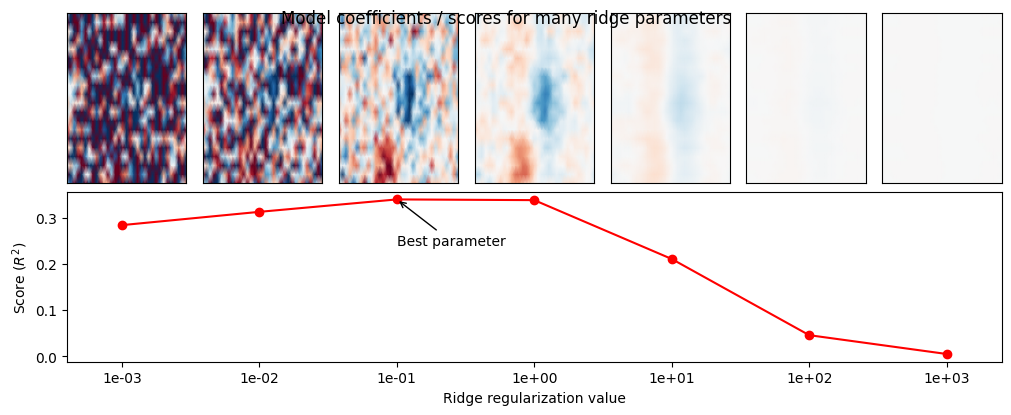

In [8]:
# Plot model score for each ridge parameter
fig = plt.figure(figsize=(10, 4), layout="constrained")
ax = plt.subplot2grid([2, len(alphas)], [1, 0], 1, len(alphas))
ax.plot(np.arange(len(alphas)), scores, marker="o", color="r")
ax.annotate(
    "Best parameter",
    (ix_best_alpha, scores[ix_best_alpha]),
    (ix_best_alpha, scores[ix_best_alpha] - 0.1),
    arrowprops={"arrowstyle": "->"},
)
plt.xticks(np.arange(len(alphas)), [f"{ii:.0e}" for ii in alphas])
ax.set(
    xlabel="Ridge regularization value",
    ylabel="Score ($R^2$)",
    xlim=[-0.4, len(alphas) - 0.6],
)

# Plot the STRF of each ridge parameter
for ii, (rf, i_alpha) in enumerate(zip(models, alphas)):
    ax = plt.subplot2grid([2, len(alphas)], [0, ii], 1, 1)
    ax.pcolormesh(times, rf.feature_names, rf.coef_[0], **kwargs)
    plt.xticks([], [])
    plt.yticks([], [])
fig.suptitle("Model coefficients / scores for many ridge parameters", y=1)

## Using different regularization types




In [9]:
scores_lap = np.zeros_like(alphas)
models_lap = []
for ii, alpha in enumerate(alphas):
    estimator = TimeDelayingRidge(tmin, tmax, sfreq, reg_type="laplacian", alpha=alpha)
    rf = ReceptiveField(tmin, tmax, sfreq, freqs, estimator=estimator)
    rf.fit(X_train, y_train)

    # Now make predictions about the model output, given input stimuli.
    scores_lap[ii] = rf.score(X_test, y_test).item()
    models_lap.append(rf)

ix_best_alpha_lap = np.argmax(scores_lap)

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Fitting 15 epochs, 20 channels


  0%|          | Sample : 0/3450 [00:00<?,       ?it/s]

Text(0.5, 1, 'Model coefficients / scores for laplacian regularization')

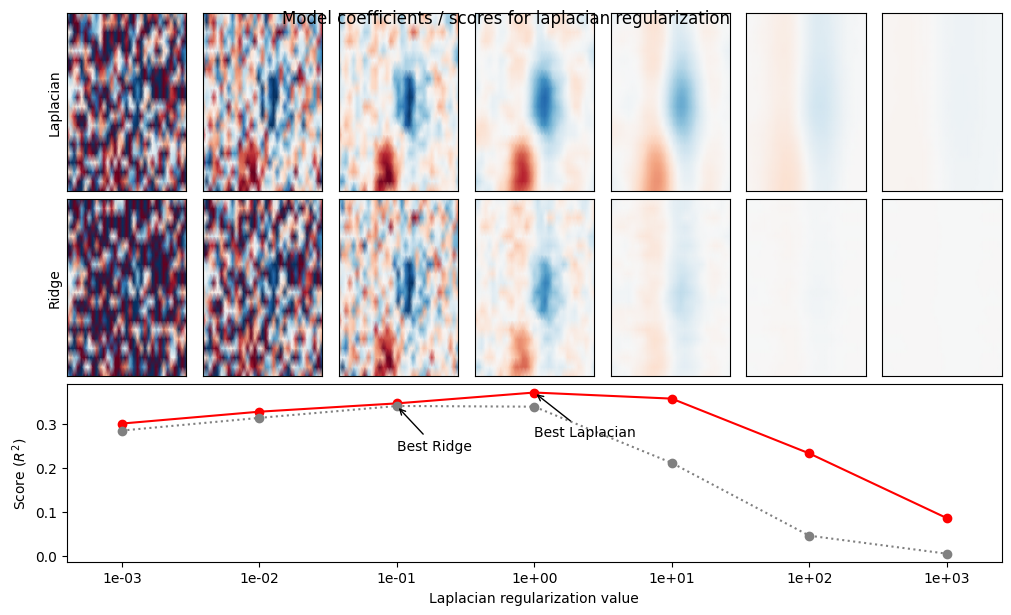

In [10]:
fig = plt.figure(figsize=(10, 6), layout="constrained")
ax = plt.subplot2grid([3, len(alphas)], [2, 0], 1, len(alphas))
ax.plot(np.arange(len(alphas)), scores_lap, marker="o", color="r")
ax.plot(np.arange(len(alphas)), scores, marker="o", color="0.5", ls=":")
ax.annotate(
    "Best Laplacian",
    (ix_best_alpha_lap, scores_lap[ix_best_alpha_lap]),
    (ix_best_alpha_lap, scores_lap[ix_best_alpha_lap] - 0.1),
    arrowprops={"arrowstyle": "->"},
)
ax.annotate(
    "Best Ridge",
    (ix_best_alpha, scores[ix_best_alpha]),
    (ix_best_alpha, scores[ix_best_alpha] - 0.1),
    arrowprops={"arrowstyle": "->"},
)
plt.xticks(np.arange(len(alphas)), [f"{ii:.0e}" for ii in alphas])
ax.set(
    xlabel="Laplacian regularization value",
    ylabel="Score ($R^2$)",
    xlim=[-0.4, len(alphas) - 0.6],
)

# Plot the STRF of each ridge parameter
xlim = times[[0, -1]]
for ii, (rf_lap, rf, i_alpha) in enumerate(zip(models_lap, models, alphas)):
    ax = plt.subplot2grid([3, len(alphas)], [0, ii], 1, 1)
    ax.pcolormesh(times, rf_lap.feature_names, rf_lap.coef_[0], **kwargs)
    ax.set(xticks=[], yticks=[], xlim=xlim)
    if ii == 0:
        ax.set(ylabel="Laplacian")
    ax = plt.subplot2grid([3, len(alphas)], [1, ii], 1, 1)
    ax.pcolormesh(times, rf.feature_names, rf.coef_[0], **kwargs)
    ax.set(xticks=[], yticks=[], xlim=xlim)
    if ii == 0:
        ax.set(ylabel="Ridge")
fig.suptitle("Model coefficients / scores for laplacian regularization", y=1)

Plot the original STRF, and the one that we recovered with modeling.



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

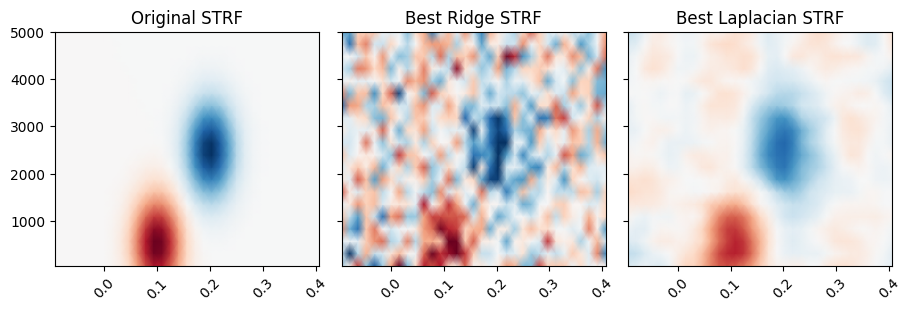

In [11]:
rf = models[ix_best_alpha]
rf_lap = models_lap[ix_best_alpha_lap]
_, (ax1, ax2, ax3) = plt.subplots(
    1,
    3,
    figsize=(9, 3),
    sharey=True,
    sharex=True,
    layout="constrained",
)
ax1.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax2.pcolormesh(times, rf.feature_names, rf.coef_[0], **kwargs)
ax3.pcolormesh(times, rf_lap.feature_names, rf_lap.coef_[0], **kwargs)
ax1.set_title("Original STRF")
ax2.set_title("Best Ridge STRF")
ax3.set_title("Best Laplacian STRF")
plt.setp([iax.get_xticklabels() for iax in [ax1, ax2, ax3]], rotation=45)